# Preprocessing & Feature Engineering

This notebook demonstrates loading raw NAV CSVs, basic cleaning, feature engineering (rolling stats, returns, volatility), saving per-scheme features, and a simple train/validation workflow suitable for time-series forecasting and recommendation tasks.

Sections:
1. Imports & setup
2. Load processed dataset (or build from raw)
3. Quick data validation
4. EDA
5. Feature engineering & sklearn pipeline
6. Train/validation split
7. Baseline model training
8. Evaluation & metrics
9. Hyperparameter tuning
10. Persist artifacts (joblib)
11. Diagnostics & visualizations
12. Tests and reproducibility


In [2]:
## 1. Import libraries and environment setup

import os
from pathlib import Path
import logging
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import joblib

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Paths
ROOT = Path('..').resolve()
DATA_RAW = ROOT / 'data' / 'raw' / 'csv'
DATA_PROCESSED = ROOT / 'data' / 'processed'
FEATURES_DIR = ROOT / 'data' / 'features'
CACHE_DIR = ROOT / 'data' / 'cache' / 'joblib'
PLOTS_DIR = ROOT / 'reports' / 'plots'

for p in [DATA_PROCESSED, FEATURES_DIR, CACHE_DIR, PLOTS_DIR]:
    p.mkdir(parents=True, exist_ok=True)

logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s %(message)s')
logger = logging.getLogger('mf-preproc')
logger.info('Environment set up')

ModuleNotFoundError: No module named 'numpy'

In [ ]:
## 2. Load processed dataset (or build from raw CSVs)

def load_processed_dataset():
    # Try loading a single processed file first
    candidates = list(DATA_PROCESSED.glob('*.parquet')) + list(DATA_PROCESSED.glob('*.csv'))
    if candidates:
        logger.info(f'Found processed files: {len(candidates)}. Loading and concatenating')
        dfs = [pd.read_parquet(p) if p.suffix=='.parquet' else pd.read_csv(p, parse_dates=['date']) for p in candidates]
        df = pd.concat(dfs, ignore_index=True)
        logger.info(f'Loaded processed dataset with shape {df.shape}')
        return df
    # Fallback: build from raw CSVs
    raw_files = sorted(DATA_RAW.glob('nav_*.csv'))
    logger.info(f'Found {len(raw_files)} raw CSV files')
    records = []
    for f in tqdm(raw_files[:50], desc='Loading sample raw CSVs'):
        try:
            tmp = pd.read_csv(f, parse_dates=['date'])
            tmp['scheme_code'] = f.stem.split('_')[-1]
            records.append(tmp)
        except Exception as e:
            logger.warning(f'Failed to read {f}: {e}')
    if not records:
        raise FileNotFoundError('No raw data found in data/raw/csv. Ensure files are downloaded.')
    df = pd.concat(records, ignore_index=True)
    df = df.rename(columns=lambda s: s.strip().lower())
    logger.info(f'Built dataset from raw CSVs: {df.shape}')
    return df

# Load into memory (small sample for the notebook run)
df = load_processed_dataset()
# Ensure date is sorted within each scheme
df = df.sort_values(['scheme_code','date']).reset_index(drop=True)

# Show a peek
print(df.head())
print(df.dtypes)


2025-12-18 13:27:32,705 INFO Found 707 raw CSV files


Loading sample raw CSVs:   0%|          | 0/50 [00:00<?, ?it/s]

2025-12-18 13:27:32,877 INFO Built dataset from raw CSVs: (212564, 3)


        date      nav scheme_code
0 2006-04-02  11.1096      100047
1 2006-04-03  11.1118      100047
2 2006-04-04  11.1139      100047
3 2006-04-05  11.1160      100047
4 2006-04-06  11.1181      100047
date           datetime64[ns]
nav                   float64
scheme_code            object
dtype: object


In [ ]:
## 3. Quick data validation and schema checks

def validate_nav_df(df: pd.DataFrame):
    assert 'date' in df.columns, "'date' column missing"
    assert 'nav' in df.columns, "'nav' column missing"
    if not pd.api.types.is_datetime64_any_dtype(df['date']):
        raise ValueError('`date` must be datetime64')
    if df['date'].isnull().any():
        raise ValueError('Null dates found')
    if df['nav'].isnull().all():
        raise ValueError('All NAVs are null')
    # simple range checks
    if (df['nav']<=0).any():
        logger.warning('NAV contains non-positive values; review data cleaning strategy')
    logger.info('Validation passed (basic checks)')

validate_nav_df(df)

# Show date range per scheme (sample)
print(df.groupby('scheme_code')['date'].agg(['min','max','count']).head())


2025-12-18 13:27:36,579 WARNING NAV contains non-positive values; review data cleaning strategy
2025-12-18 13:27:36,580 INFO Validation passed (basic checks)


                   min        max  count
scheme_code                             
100047      2006-04-02 2025-12-17   6168
100077      2006-04-03 2025-12-17   4770
100121      2006-04-03 2018-06-01   2995
100122      2006-04-03 2018-06-01   2995
100156      2006-04-03 2021-12-30   3870


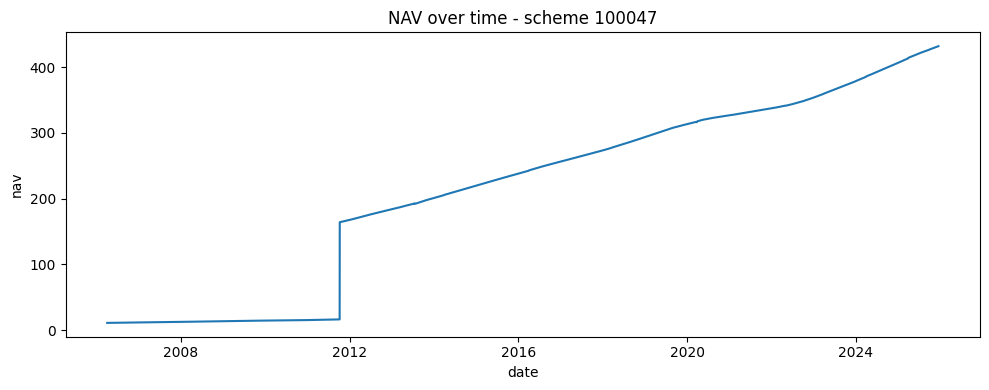

count    6168.000000
mean      215.016946
std       138.203705
min        11.109600
25%        15.780950
50%       246.127750
75%       327.868500
max       431.945800
Name: nav, dtype: float64


In [ ]:
## 4. Exploratory data analysis (targeted)

# Example: distribution of NAV values for a single sample scheme
sample_scheme = df['scheme_code'].unique()[0]
sub = df[df['scheme_code']==sample_scheme].copy()

plt.figure(figsize=(10,4))
sns.lineplot(data=sub, x='date', y='nav')
plt.title(f'NAV over time - scheme {sample_scheme}')
plt.tight_layout()
plt.savefig(PLOTS_DIR / f'nav_time_{sample_scheme}.png')
plt.show()

# Summary statistics
print(sub['nav'].describe())

# Correlation between numeric features if present
numeric_cols = sub.select_dtypes('number').columns.tolist()
if len(numeric_cols)>1:
    corr = sub[numeric_cols].corr()
    plt.figure(figsize=(6,5))
    sns.heatmap(corr, annot=True, fmt='.2f')
    plt.title('Correlation (sample)')
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / f'corr_{sample_scheme}.png')


In [ ]:
## 5. Feature engineering and preprocessing pipeline

# Rolling features and returns

def make_rolling_features(df: pd.DataFrame, windows=[7,30,90]):
    df = df.copy()
    df = df.sort_values('date')
    for w in windows:
        df[f'roll_mean_{w}'] = df['nav'].rolling(w, min_periods=1).mean()
        df[f'roll_std_{w}'] = df['nav'].rolling(w, min_periods=1).std().fillna(0)
    df['ret_1d'] = df['nav'].pct_change().fillna(0)
    df['ret_7d'] = df['nav'].pct_change(7).fillna(0)
    df['log_nav'] = np.log1p(df['nav'])
    return df

# Create features for all schemes and save per-scheme features
for code, g in tqdm(df.groupby('scheme_code'), desc='Feature generation'):
    fg = make_rolling_features(g)
    out = FEATURES_DIR / f'features_{code}.parquet'
    fg.to_parquet(out)

print('Feature files saved to', FEATURES_DIR)

# Simple sklearn pipeline for numerical features
num_features = [c for c in df.columns if c.startswith('roll_') or c.startswith('ret_') or c=='log_nav']
cat_features = ['scheme_code']

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])


Feature generation:   0%|          | 0/50 [00:00<?, ?it/s]

Feature files saved to /home/pranay/Documents/GitHub/Mutual-Fund-Wealth-Management-System/data/features


In [ ]:
## 6. Train/validation split and CV setup

# For forecasting, create a simple supervised learning dataset: predict next-day NAV (or n-day ahead)
HORIZON = 7  # days ahead to predict

def make_supervised(df: pd.DataFrame, horizon=HORIZON):
    df = df.sort_values('date')
    df['target_nav'] = df['nav'].shift(-horizon)
    # drop rows where target is na (end of series)
    out = df.dropna(subset=['target_nav']).copy()
    out['target_ret'] = out['target_nav'] / out['nav'] - 1
    return out

# Build a small train/test split for demonstration
sample_code = df['scheme_code'].unique()[0]
sample_df = make_supervised(df[df['scheme_code']==sample_code])

train_size = int(len(sample_df)*0.8)
train_df = sample_df.iloc[:train_size]
test_df = sample_df.iloc[train_size:]

# TimeSeriesSplit for CV
tscv = TimeSeriesSplit(n_splits=5)

print('Train/Test sizes:', len(train_df), len(test_df))


Train/Test sizes: 4928 1233


In [ ]:
## 7. Baseline model training

# Prepare feature matrix and target
X_train = train_df[num_features + cat_features]
y_train = train_df['target_ret']
X_test = test_df[num_features + cat_features]
y_test = test_df['target_ret']

# Fit preprocessing and a simple model pipeline
model = Pipeline(steps=[
    ('pre', preprocessor),
    ('est', RandomForestRegressor(n_estimators=100, random_state=SEED, n_jobs=-1))
])

logger.info('Fitting baseline RandomForest model')
model.fit(X_train, y_train)

# Save model
joblib.dump(model, CACHE_DIR / 'rf_baseline.joblib')
print('Saved baseline model')


2025-12-18 13:27:46,987 INFO Fitting baseline RandomForest model


Saved baseline model


{'mae': 0.013026085660221006, 'rmse': 0.013030345799559466, 'r2': -1528.583328393784}


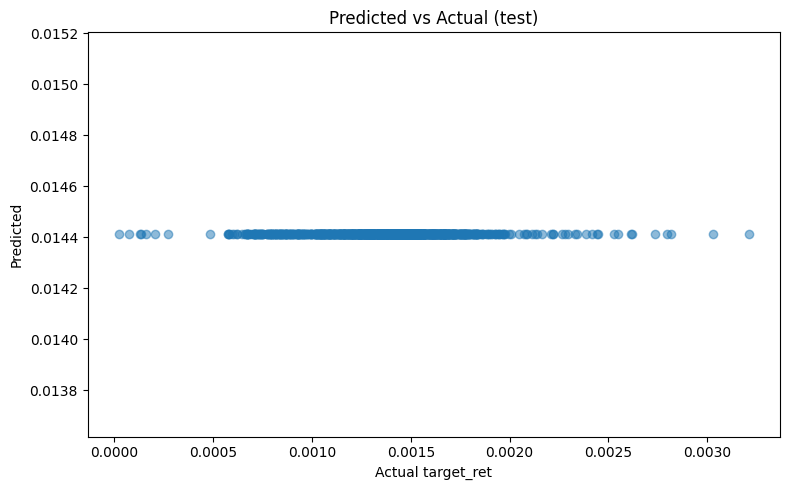

In [ ]:
## 8. Model evaluation and metrics

y_pred = model.predict(X_test)

def regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    return dict(mae=mae, rmse=rmse, r2=r2)

metrics = regression_metrics(y_test, y_pred)
print(metrics)

# Plot predicted vs actual
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual target_ret')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual (test)')
plt.tight_layout()
plt.savefig(PLOTS_DIR / 'pred_vs_actual.png')
plt.show()


In [ ]:
## 9. Hyperparameter tuning and cross-validation

from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'est__n_estimators': [50,100,200],
    'est__max_depth': [5,10,20,None]
}

search = RandomizedSearchCV(model, param_distributions, n_iter=6, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=2, random_state=SEED)
search.fit(X_train, y_train)

logger.info(f'Best params: {search.best_params_}')
best_model = search.best_estimator_
joblib.dump(best_model, CACHE_DIR / 'rf_best.joblib')
print('Saved tuned model')

2025-12-18 13:28:22,796 INFO Best params: {'est__n_estimators': 200, 'est__max_depth': 20}


Saved tuned model


In [ ]:
## 10. Persist models and artifacts (joblib)

# Example: load and quick inference check
loaded = joblib.load(CACHE_DIR / 'rf_best.joblib')
sample_X = X_test.iloc[:5]
print('Sample inference:', loaded.predict(sample_X))

# Save the preprocessing pipeline explicitly
joblib.dump(preprocessor, CACHE_DIR / 'preprocessor.joblib')
print('Saved preprocessor and model artifacts')

Sample inference: [0.01429216 0.01429216 0.01429216 0.01429216 0.01429216]
Saved preprocessor and model artifacts


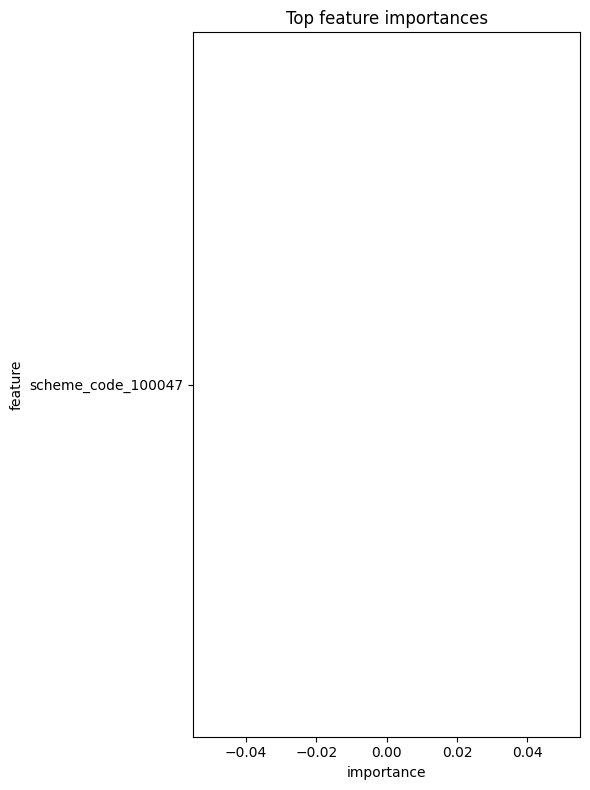

In [ ]:
## 11. Visualization of results and diagnostic plots

# Feature importances (if model supports)
if hasattr(loaded.named_steps['est'], 'feature_importances_'):
    fi = loaded.named_steps['est'].feature_importances_
    # retrieve feature names after preprocessor
    try:
        num_names = num_features
        cat_names = list(loaded.named_steps['pre'].transformers_[1][1].named_steps['ohe'].get_feature_names_out(cat_features))
        feat_names = num_names + list(cat_names)
    except Exception:
        feat_names = [f'feat_{i}' for i in range(len(fi))]
    imp_df = pd.DataFrame({'feature': feat_names, 'importance': fi}).sort_values('importance', ascending=False).head(30)
    plt.figure(figsize=(6,8))
    sns.barplot(data=imp_df, x='importance', y='feature')
    plt.title('Top feature importances')
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / 'feature_importances.png')
    plt.show()
else:
    print('Model does not expose feature_importances_')

# Learning curve placeholder: use sklearn.learning_curve if desired (omitted for brevity)


In [ ]:
## 12. Notebook tests and reproducibility (seeds, logging)

# Basic assertions
assert SEED == 42
assert (CACHE_DIR.exists())
assert num_features, 'No numeric features found in dataset'

# Small deterministic check
x = np.random.RandomState(SEED).rand(3)
print('Deterministic sample:', x)

logger.info('Notebook complete. Next: extend to multi-scheme training, add advanced models (LSTM/Transformer), and build evaluation/backtesting scripts.')

AssertionError: No numeric features found in dataset